In [1]:
# !curl http://localhost:3000/export.php -o puppeteer.csv


=== Mean & Median Feature Values by Class ===
label                     0 (mean)  0 (median)  1 (mean)  1 (median)
session_duration            10.700       5.000     8.869       9.000
pages_visited                1.513       1.000     1.000       1.000
avg_time_per_page           16.875       6.000     8.350       8.000
mouse_distance_avg        2422.862    1291.395  1714.273    1709.990
mouse_avg_speed           1122.166    1010.850  1129.592    1118.879
mouse_max_speed           5411.336    4882.480  4654.453    3404.717
mouse_sharp_turns          194.659     121.000    92.879     104.000
mouse_straight_movements    21.310      12.000    10.474      11.000
avg_scroll_depth          3409.670    2420.000  4352.465    2337.500
avg_scroll_speed          1030.065     785.696  1364.447     771.680
total_scrolls              985.245     138.000   233.163     204.500
total_clicks                 3.669       0.000     0.000       0.000
avg_typing_speed            28.487       0.000     0.573

c:\ProgramData\anaconda3\envs\research\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:25:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.97      0.99      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



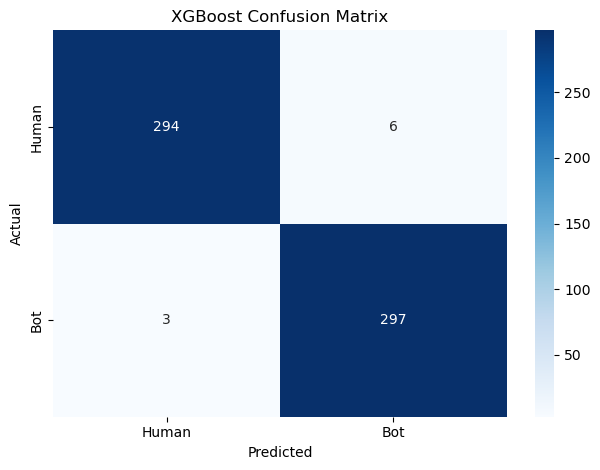

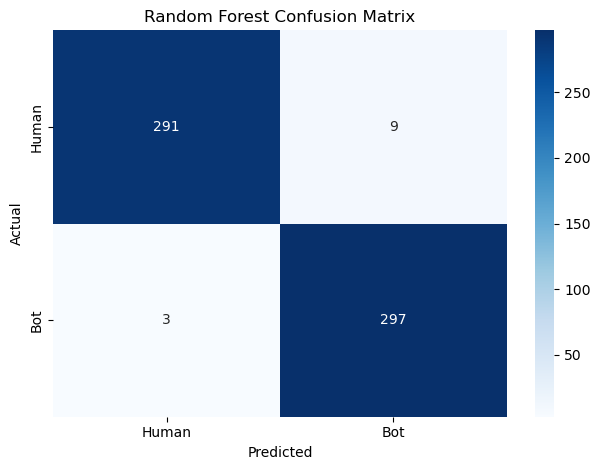

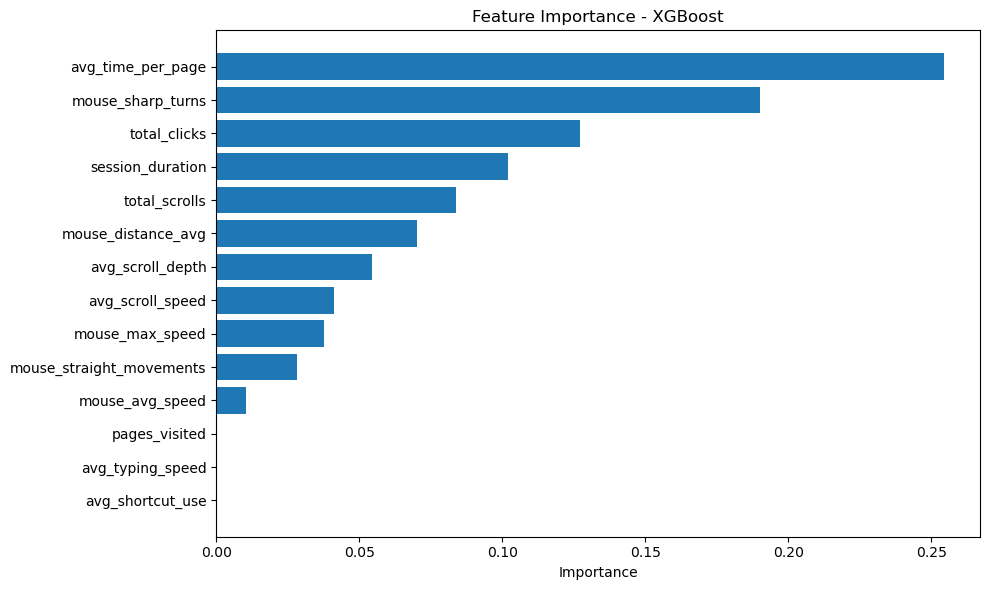

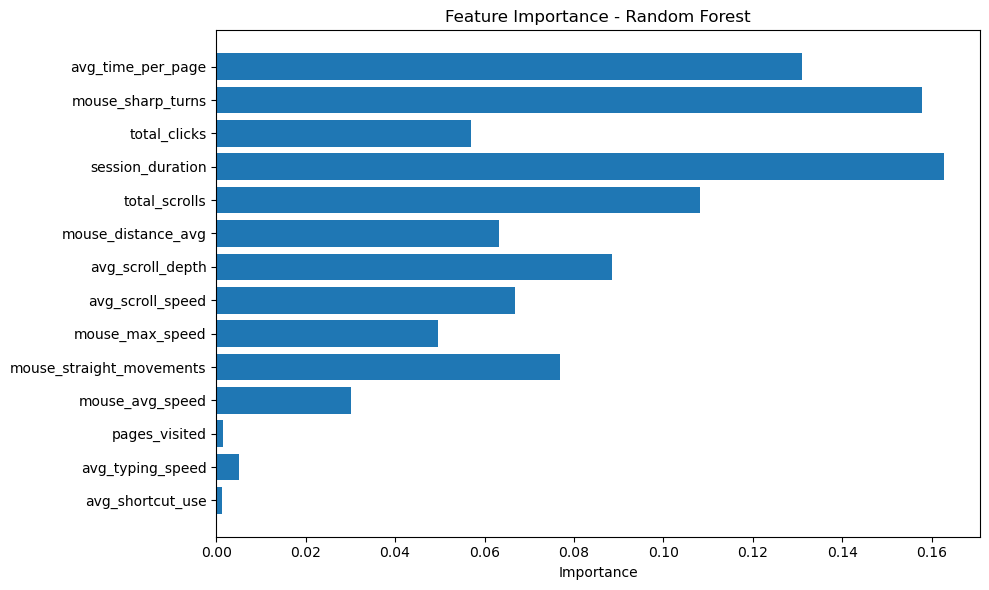

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import shap
import numpy as np

# --- Load datasets ---
df_puppeteer = pd.read_csv("puppeteer.csv")
df_humans = pd.read_csv("humans.csv")

# --- Label datasets ---
df_puppeteer["label"] = 1
df_humans["label"] = 0

# --- Combine into a single dataframe ---
df = pd.concat([ df_puppeteer, df_humans], ignore_index=True)
df.to_csv("combined_sessions.csv", index=False)

# --- Cleanup and prepare features ---
df = df.drop(columns=[
"session_id", "mouse_idle_time", "avg_time_between_clicks", #Mouse idle time and avg time between clicks not recorded due to being empty and browser dependent behaviour

    # "avg_time_per_page",
    # "total_scrolls",
    # "session_duration",
    # "avg_typing_speed",
    # "total_clicks",
    # "pages_visited",
    # "mouse_distance_avg",
    # "mouse_sharp_turns",
    # "avg_scroll_depth",
    # "avg_scroll_speed",
    # "mouse_avg_speed",
    # "mouse_straight_movements",
    # "mouse_max_speed",
    # "avg_shortcut_use"
], errors="ignore")
df = df.select_dtypes(include=["number"])  # keep only numeric data

from scipy.stats.mstats import winsorize

winsor_cols = [
    "avg_time_per_page",
    "total_scrolls",
    "session_duration",
    "avg_typing_speed",
    "total_clicks",
    "avg_time_between_clicks",
    "pages_visited",
    "mouse_distance_avg",
    "mouse_sharp_turns",
    "avg_scroll_depth",
    "avg_scroll_speed",
    "mouse_avg_speed",
    "mouse_straight_movements",
    "mouse_max_speed",
    "avg_shortcut_use"
]

for col in winsor_cols:
    if col in df.columns:
        df[col] = winsorize(df[col], limits=(0.0, 0.01))  # Cap top 1%
X = df.drop(columns=["label"])
y = df["label"]

# --- Train-test split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Class Weight Calculation ---
# (e.g., if humans: 800, bots: 200 → weight = 800/200 = 4.0)
bot_weight = (y_train == 0).sum() / (y_train == 1).sum()

# --- Feature Means by Label ---
print("\n=== Mean & Median Feature Values by Class ===")
mean_df = df.groupby("label").mean().T
median_df = df.groupby("label").median().T

# Combine both mean and median into a single DataFrame
combined = pd.concat(
    [mean_df.add_suffix(" (mean)"), median_df.add_suffix(" (median)")],
    axis=1
)

# Sort columns so mean/median pairs are adjacent per label
combined = combined[
    sorted(combined.columns, key=lambda x: (x.split()[0], x.split()[1]))
]

print(combined.round(3))  # Optional: round for cleaner display

# --- XGBoost training with class weight ---
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=bot_weight  # penalize false negatives
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("\nXGBoost Classification Report:\n", classification_report(y_val, y_pred_xgb))

# --- Random Forest training with class weight ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
y_prob_rf = rf_model.predict_proba(X_val)[:, 1]

print("\nRandom Forest Classification Report:\n", classification_report(y_val, y_pred_rf))

# --- Confusion Matrix ---
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_val, y_pred_xgb, "XGBoost Confusion Matrix")
plot_conf_matrix(y_val, y_pred_rf, "Random Forest Confusion Matrix")


importances_xgb = xgb_model.feature_importances_
importances_rf = rf_model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "XGBoost Importance": importances_xgb,
    "Random Forest Importance": importances_rf
})

# Sort by XGBoost importance (or change to "Random Forest Importance" if preferred)
importance_df = importance_df.sort_values(by="XGBoost Importance", ascending=False)

# --- Plot XGBoost ---
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["XGBoost Importance"])
plt.gca().invert_yaxis()  # Most important on top
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- Plot Random Forest ---
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Random Forest Importance"])
plt.gca().invert_yaxis()  # Same order as XGBoost
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()